# 농산물 가격 및 기상 데이터 분석 및 시각화

## 1. 라이브러리 임포트

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # 스케일링을 위해 추가

# 한글 폰트 설정 (Windows 환경)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False # 마이너스 폰트 깨짐 방지

## 2. 데이터 로드 및 초기 탐색

In [ ]:
# 파일 경로
price_file = 'region_price.xlsx'
weather_file = 'region_weather.csv'
cold_file = 'mon_cold.xlsx'
hot_file = 'mon_hot.xlsx'
wind_file = 'mon_wind.xlsx'

# 데이터 로드
df_price = pd.read_excel(price_file)
df_weather = pd.read_csv(weather_file)
df_cold = pd.read_excel(cold_file)
df_hot = pd.read_excel(hot_file)
df_wind = pd.read_excel(wind_file)


# 각 데이터프레임 확인
print("\n--- 가격 데이터 (df_price) ---")
print(df_price.head())
print("\n--- 날씨 데이터 (df_weather) ---")
print(df_weather.head())
print("\n--- 한파 데이터 (df_cold) ---")
print(df_cold.head())
print("\n--- 폭염 데이터 (df_hot) ---")
print(df_hot.head())
print("\n--- 태풍 데이터 (df_wind) ---")
print(df_wind.head())


--- 가격 데이터 (df_price) ---
        지역       날짜  품목          평균가격      총거래물량
0      강원도  2021-01  감자  24245.289659  3012880.0
1      경기도  2021-01  감자  24006.188904   356360.0
2  제주특별자치도  2021-01  감자  37886.008230   330480.0
3     경상남도  2021-01  감자  27559.604013   533300.0
4     경상북도  2021-01  감자  24701.552614   462160.0

--- 날씨 데이터 (df_weather) ---
    지역       날짜   평균기온(°C)  월합강수량(00~24h만)(mm)  평균풍속(m/s)  최심적설(cm)
0  강원도  2019-01  -1.857143            4.678571   1.714286      17.1
1  강원도  2019-02   0.585714           22.928571   1.614286      17.1
2  강원도  2019-03   5.885714           41.657143   1.892857       NaN
3  강원도  2019-04  10.535714           61.278571   1.850000       NaN
4  강원도  2019-05  18.250000           14.864286   1.950000       NaN

--- 한파 데이터 (df_cold) ---
     지역  2020-11  2020-12  2021-01  2021-02  2021-03  2021-04  2021-11  \
0   경기도        0        1        1        0        0        0        0   
1   강원도        0        1        1        1        0        0       

## 3. 데이터 전처리

In [3]:
# 날짜 컬럼을 datetime 형식으로 변환
df_price["날짜"] = pd.to_datetime(df_price["날짜"])
df_weather["날짜"] = pd.to_datetime(df_weather["날짜"])

# 가격 데이터의 "평균가격"과 "총거래물량" 컬럼을 숫자형으로 변환 (오류 발생 시 NaN으로 처리)
df_price["평균가격"] = pd.to_numeric(df_price["평균가격"], errors="coerce")
df_price["총거래물량"] = pd.to_numeric(df_price["총거래물량"], errors="coerce")

# 날씨 데이터 컬럼명 정리 (사용자 제공 형식에 따라)
weather_cols = ["지역", "날짜", "평균기온(°C)", "월합강수량(00~24h만)(mm)", "평균풍속(m/s)", "최심적설(cm)"]
if len(df_weather.columns) == len(weather_cols):
    df_weather.columns = weather_cols
else:
    print("\n경고: 날씨 데이터의 컬럼 수가 예상과 다릅니다. 컬럼명을 수동으로 확인해주세요.")
    print(df_weather.columns)

# 이벤트 데이터 전처리 함수
def preprocess_event_df(df, event_name):
    # 첫 번째 컬럼을 "지역"으로 설정하고 나머지 컬럼은 날짜로 간주
    df_melted = df.melt(id_vars=[df.columns[0]], var_name="날짜", value_name=f"{event_name}_발생")
    df_melted.rename(columns={df.columns[0]: "지역"}, inplace=True)
    # YYYY-MM 형식의 날짜를 datetime으로 변환 후 월 단위로 통일
    df_melted["날짜"] = pd.to_datetime(df_melted["날짜"], format="%Y-%m")
    df_melted["날짜"] = df_melted["날짜"] .dt.to_period('M')
    return df_melted

df_cold_processed = preprocess_event_df(df_cold, "한파")
df_hot_processed = preprocess_event_df(df_hot, "폭염")
df_wind_processed = preprocess_event_df(df_wind, "태풍")

print("\n--- 전처리된 한파 데이터 (df_cold_processed) ---")
print(df_cold_processed.head())
print("\n--- 전처리된 폭염 데이터 (df_hot_processed) ---")
print(df_hot_processed.head())
print("\n--- 전처리된 태풍 데이터 (df_wind_processed) ---")
print(df_wind_processed.head())


--- 전처리된 한파 데이터 (df_cold_processed) ---
     지역       날짜  한파_발생
0   경기도  2020-11      0
1   강원도  2020-11      0
2  전라남도  2020-11      0
3  경상남도  2020-11      0
4  경상북도  2020-11      0

--- 전처리된 폭염 데이터 (df_hot_processed) ---
     지역       날짜  폭염_발생
0   경기도  2020-06      1
1   강원도  2020-06      1
2  전라남도  2020-06      1
3  경상남도  2020-06      1
4  경상북도  2020-06      1

--- 전처리된 태풍 데이터 (df_wind_processed) ---
        지역       날짜  태풍_발생
0  제주특별자치도  2020-08      1
1      강원도  2020-08      1
2     전라남도  2020-08      1
3     경상남도  2020-08      1
4    광주광역시  2020-08      1


## 4. 가격 및 날씨 데이터 통합

In [4]:
# 날씨 데이터의 날짜를 월 단위로 통일
df_weather["날짜"] = df_weather["날짜"].dt.to_period('M')

# 가격 데이터의 날짜를 월 단위로 통일
df_price["날짜"] = df_price["날짜"].dt.to_period('M')

# 가격 데이터와 날씨 데이터를 "지역"과 "날짜_월"을 기준으로 병합
merged_df = pd.merge(df_price, df_weather, left_on=["지역", "날짜"], right_on=["지역", "날짜"], how="left")

# 이벤트 데이터 병합
merged_df = pd.merge(merged_df, df_cold_processed, on=["지역", "날짜"], how="left")
merged_df = pd.merge(merged_df, df_hot_processed, on=["지역", "날짜"], how="left")
merged_df = pd.merge(merged_df, df_wind_processed, on=["지역", "날짜"], how="left")

# 최심적설, 한파, 폭염, 태풍의 NaN 값은 이벤트가 없었던 것으로 간주하여 0으로 채움
merged_df["최심적설(cm)"] = merged_df["최심적설(cm)"].fillna(0)
merged_df["한파_발생"] = merged_df["한파_발생"].fillna(0)
merged_df["폭염_발생"] = merged_df["폭염_발생"].fillna(0)
merged_df["태풍_발생"] = merged_df["태풍_발생"].fillna(0)

# 모든 숫자형 컬럼을 다시 숫자형으로 변환하고, 변환할 수 없는 값(NaN)이 있는 행 제거
numeric_cols = ["평균가격", "총거래물량", "평균기온(°C)", "월합강수량(00~24h만)(mm)", "평균풍속(m/s)", "최심적설(cm)"]
for col in numeric_cols:
    merged_df[col] = pd.to_numeric(merged_df[col], errors="coerce")
merged_df.dropna(subset=numeric_cols, inplace=True)

print("\n--- 최종 병합된 데이터프레임 (merged_df) ---")
print(merged_df.head())
print("\n--- 최종 병합된 데이터프레임 정보 ---")
merged_df.info()


--- 최종 병합된 데이터프레임 (merged_df) ---
        지역       날짜  품목          평균가격      총거래물량  평균기온(°C)  \
0      강원도  2021-01  감자  24245.289659  3012880.0 -3.435714   
1      경기도  2021-01  감자  24006.188904   356360.0 -3.680000   
2  제주특별자치도  2021-01  감자  37886.008230   330480.0  6.700000   
3     경상남도  2021-01  감자  27559.604013   533300.0  1.192857   
4     경상북도  2021-01  감자  24701.552614   462160.0 -1.421429   

   월합강수량(00~24h만)(mm)  평균풍속(m/s)  최심적설(cm)  한파_발생  폭염_발생  태풍_발생  
0           10.221429   1.778571       4.9    1.0    0.0    0.0  
1           18.460000   1.440000       9.4    1.0    0.0    0.0  
2           84.225000   4.575000       9.2    0.0    0.0    0.0  
3           17.678571   1.700000       0.0    1.0    0.0    0.0  
4           12.728571   2.350000       0.9    1.0    0.0    0.0  

--- 최종 병합된 데이터프레임 정보 ---
<class 'pandas.core.frame.DataFrame'>
Index: 8538 entries, 0 to 8976
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype    
---  ------      

## 5. 이상치 탐지 및 제거 (평균가격, 총거래물량)

In [5]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

columns_to_check = ["평균가격", "총거래물량"]

original_rows = len(merged_df)
for col in columns_to_check:
    if col in merged_df.columns:
        merged_df = remove_outliers_iqr(merged_df, col)
        print(f"컬럼 {col}에서 이상치 제거 후 데이터 크기: {len(merged_df)}")

print(f"\n총 {original_rows - len(merged_df)}개의 이상치 행이 제거되었습니다.")
print("이상치 제거 후 데이터프레임 정보:")
merged_df.info()

컬럼 평균가격에서 이상치 제거 후 데이터 크기: 8260
컬럼 총거래물량에서 이상치 제거 후 데이터 크기: 7034

총 1504개의 이상치 행이 제거되었습니다.
이상치 제거 후 데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 7034 entries, 2 to 8976
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype    
---  ------              --------------  -----    
 0   지역                  7034 non-null   object   
 1   날짜                  7034 non-null   period[M]
 2   품목                  7034 non-null   object   
 3   평균가격                7034 non-null   float64  
 4   총거래물량               7034 non-null   float64  
 5   평균기온(°C)            7034 non-null   float64  
 6   월합강수량(00~24h만)(mm)  7034 non-null   float64  
 7   평균풍속(m/s)           7034 non-null   float64  
 8   최심적설(cm)            7034 non-null   float64  
 9   한파_발생               7034 non-null   float64  
 10  폭염_발생               7034 non-null   float64  
 11  태풍_발생               7034 non-null   float64  
dtypes: float64(9), object(2), period[M](1)
memory usage: 714.4+ KB


## 6. 가격 데이터 시각화 (품목별 Subplot)

### 6.1. 시간 흐름에 따른 평균 가격 변화

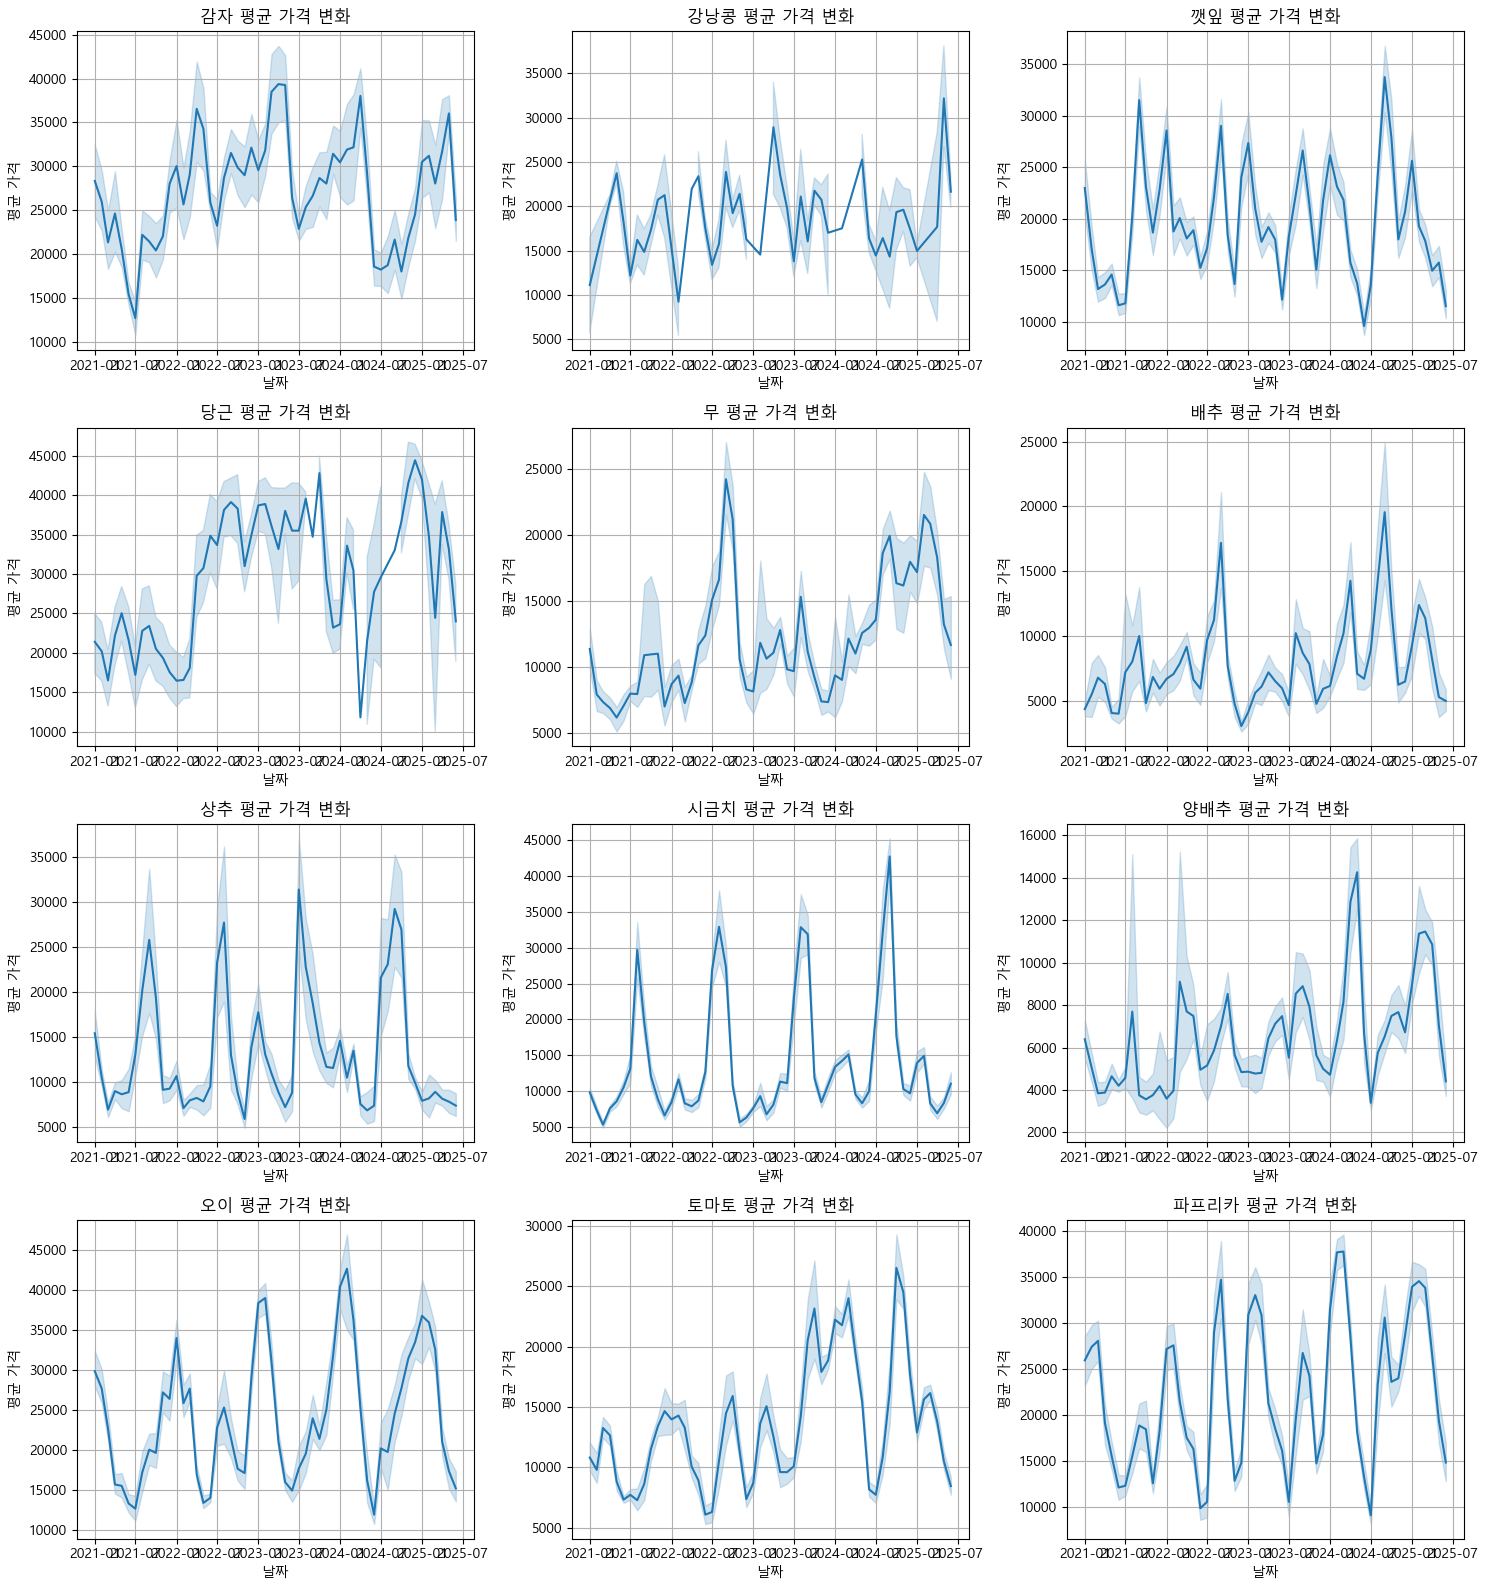

In [7]:
# 날짜를 datetime 형식으로 변환
merged_df["날짜"] = merged_df["날짜"].dt.to_timestamp()

# 평균가격 숫자형 확인 및 변환 (안전하게 다시 한 번)
merged_df["평균가격"] = pd.to_numeric(merged_df["평균가격"], errors="coerce")

# 그래프 그리기
import matplotlib.pyplot as plt
import seaborn as sns

unique_items = merged_df["품목"].unique()
n_items = len(unique_items)
n_cols = 3
n_rows = (n_items + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, item in enumerate(unique_items):
    item_df = merged_df[merged_df["품목"] == item]
    sns.lineplot(data=item_df, x="날짜", y="평균가격", ax=axes[i])
    axes[i].set_title(f"{item} 평균 가격 변화")
    axes[i].set_xlabel("날짜")
    axes[i].set_ylabel("평균 가격")
    axes[i].grid(True)

# 남은 빈 그래프 삭제
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 7. 날씨 데이터 시각화 (품목별 Subplot)

### 7.1. 평균 기온과 평균 가격의 관계 (산점도 및 비선형 회귀)

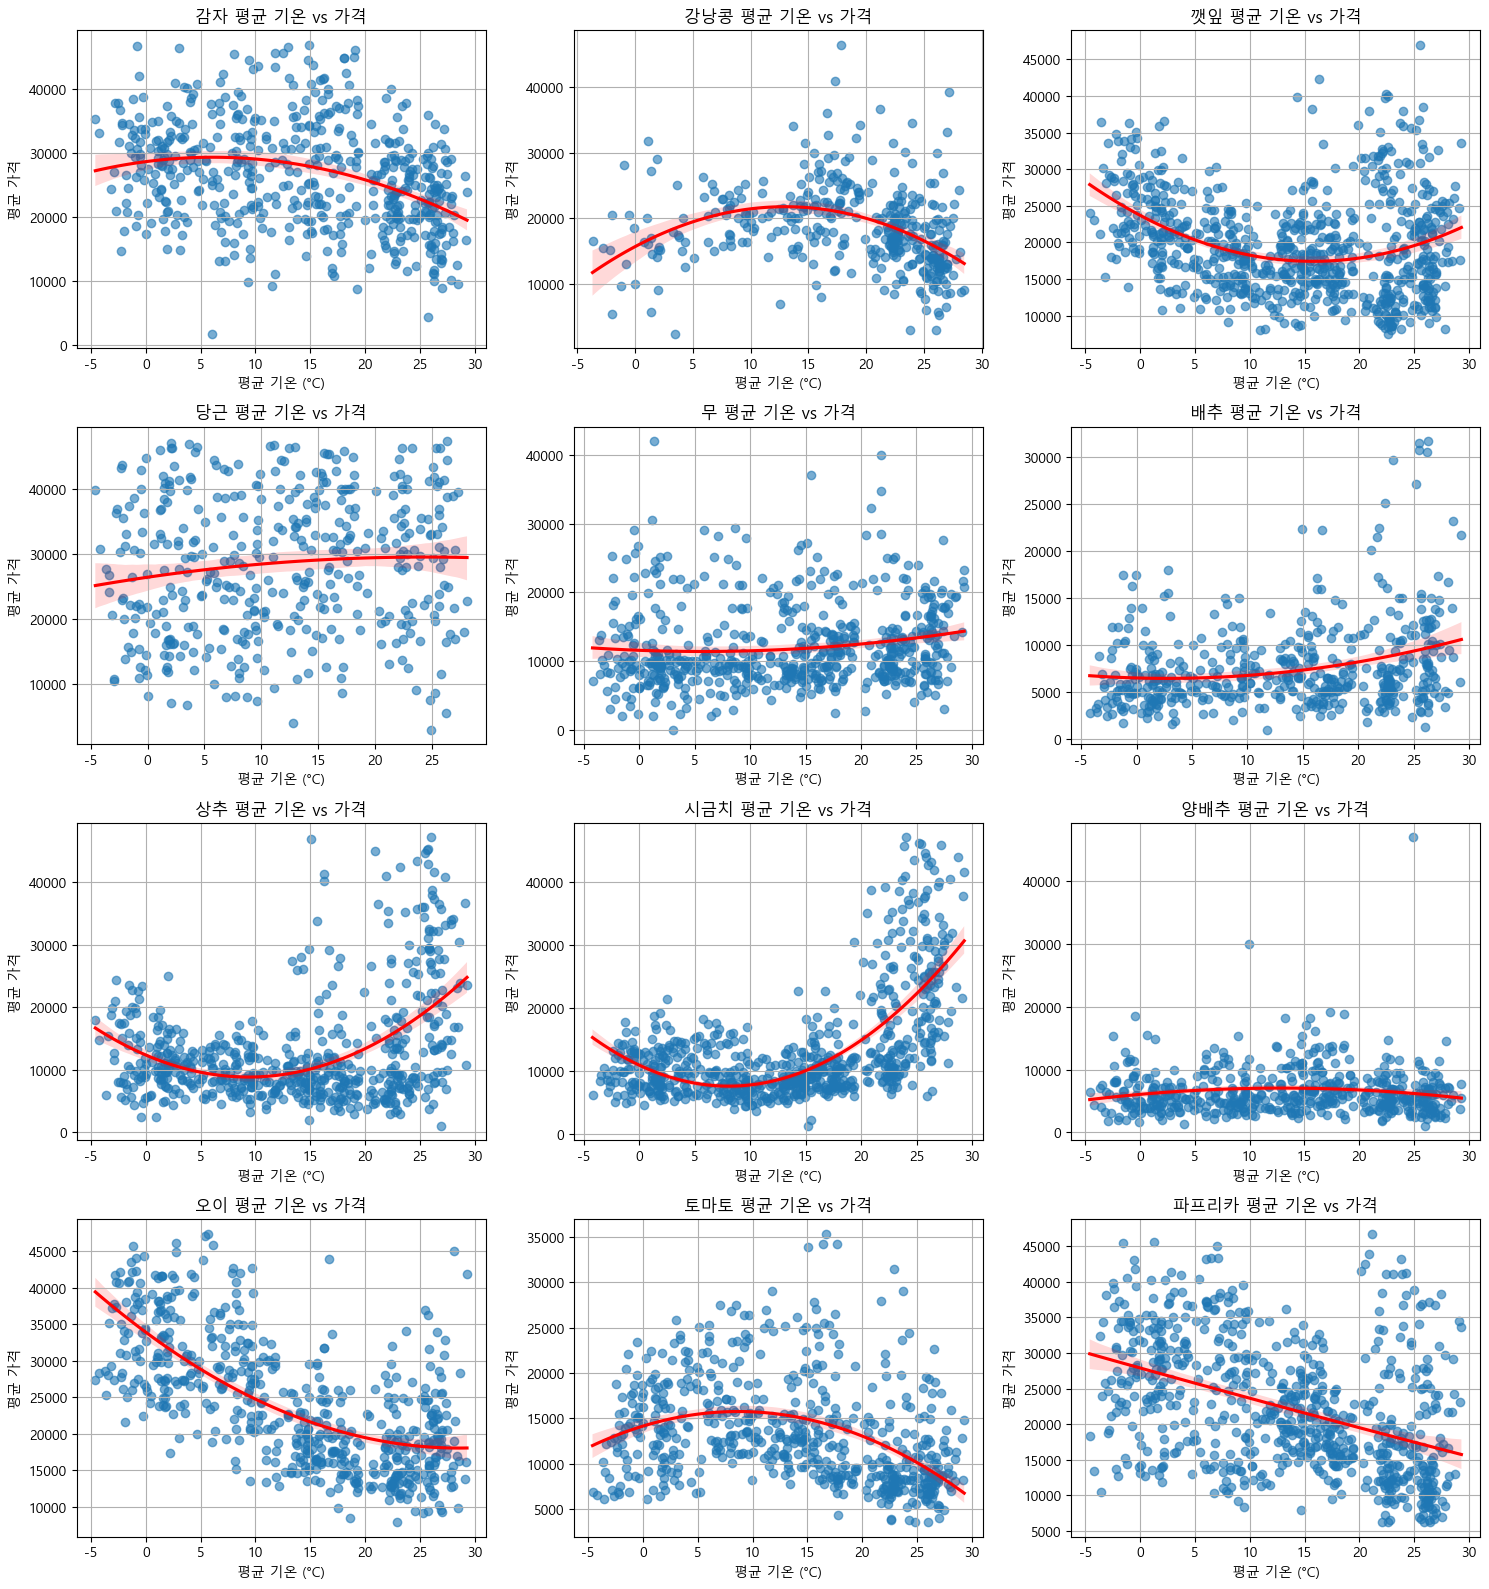

In [9]:
unique_items = merged_df["품목"] .unique()
n_items = len(unique_items)
n_cols = 3
n_rows = (n_items + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, item in enumerate(unique_items):
    sns.regplot(data=merged_df[merged_df["품목"] == item], x="평균기온(°C)", y="평균가격", order=2, scatter_kws={"alpha":0.6}, line_kws={"color":"red"}, ax=axes[i])
    axes[i].set_title(f"{item} 평균 기온 vs 가격")
    axes[i].set_xlabel("평균 기온 (°C)")
    axes[i].set_ylabel("평균 가격")
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 7.2. 월합 강수량과 평균 가격의 관계 (산점도 및 비선형 회귀)

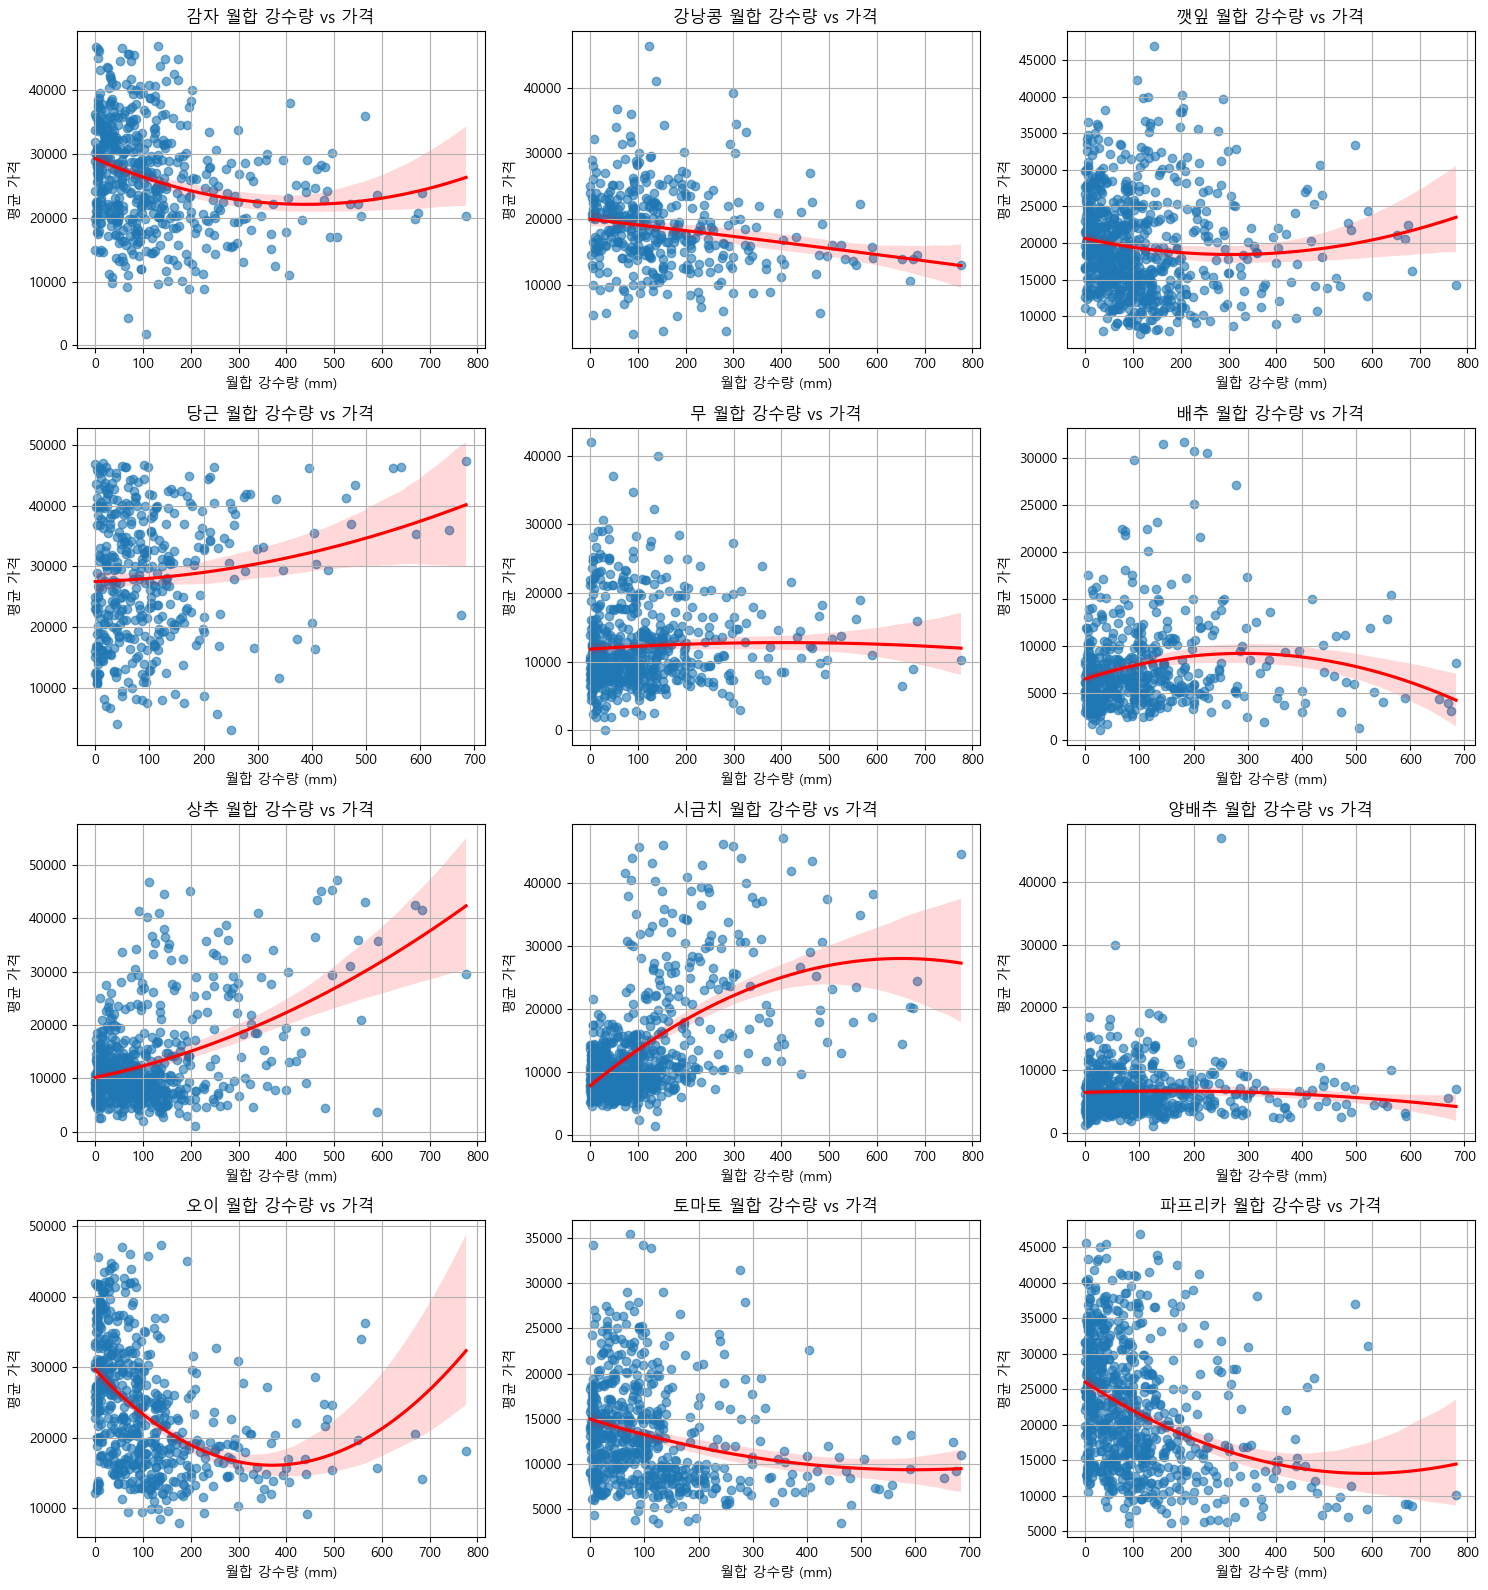

In [10]:
unique_items = merged_df["품목"] .unique()
n_items = len(unique_items)
n_cols = 3
n_rows = (n_items + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, item in enumerate(unique_items):
    sns.regplot(data=merged_df[merged_df["품목"] == item], x="월합강수량(00~24h만)(mm)", y="평균가격", order=2, scatter_kws={"alpha":0.6}, line_kws={"color":"red"}, ax=axes[i])
    axes[i].set_title(f"{item} 월합 강수량 vs 가격")
    axes[i].set_xlabel("월합 강수량 (mm)")
    axes[i].set_ylabel("평균 가격")
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [17]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7034 entries, 2 to 8976
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   지역                  7034 non-null   object        
 1   날짜                  7034 non-null   datetime64[ns]
 2   품목                  7034 non-null   object        
 3   평균가격                7034 non-null   float64       
 4   총거래물량               7034 non-null   float64       
 5   평균기온(°C)            7034 non-null   float64       
 6   월합강수량(00~24h만)(mm)  7034 non-null   float64       
 7   평균풍속(m/s)           7034 non-null   float64       
 8   최심적설(cm)            7034 non-null   float64       
 9   한파_발생               7034 non-null   float64       
 10  폭염_발생               7034 non-null   float64       
 11  태풍_발생               7034 non-null   float64       
 12  year_month          7034 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(9), object(2)
memory us

## 8. 품목별 날씨-가격 상관관계 분석 및 주요 품목 시각화 (Subplot)


--- 날씨 변수와 상관관계가 높은 상위 품목: ['오이', '시금치', '상추'] ---



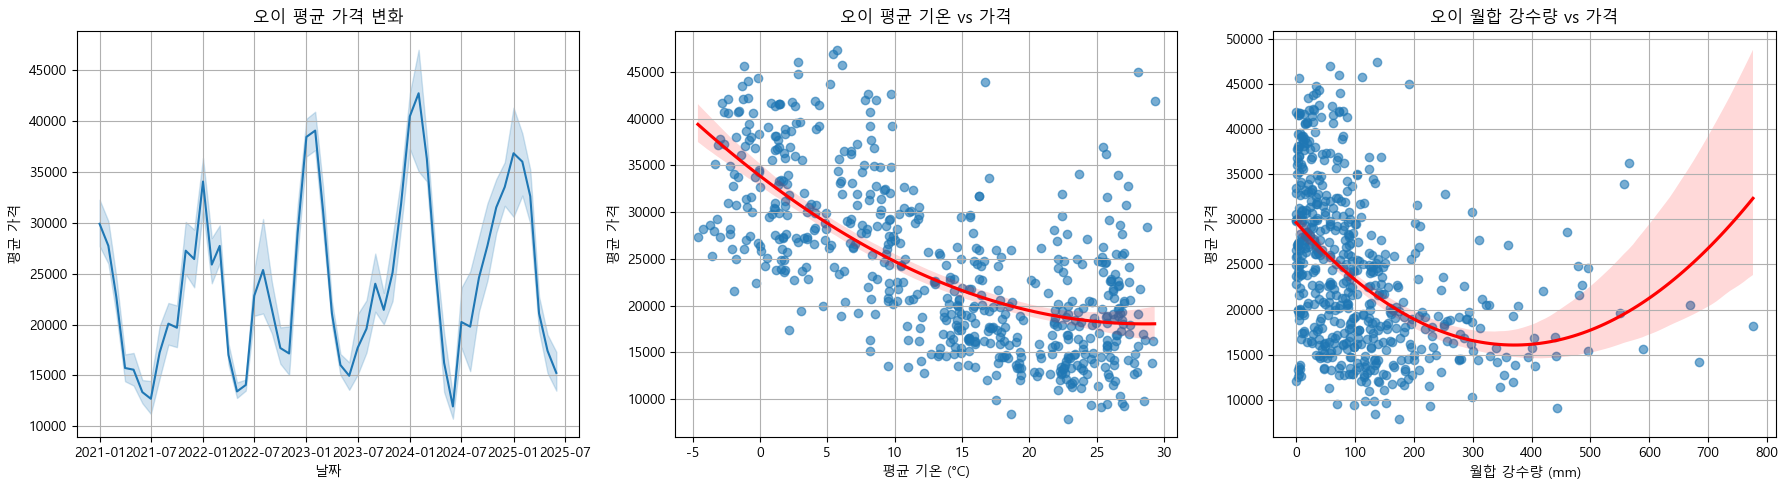

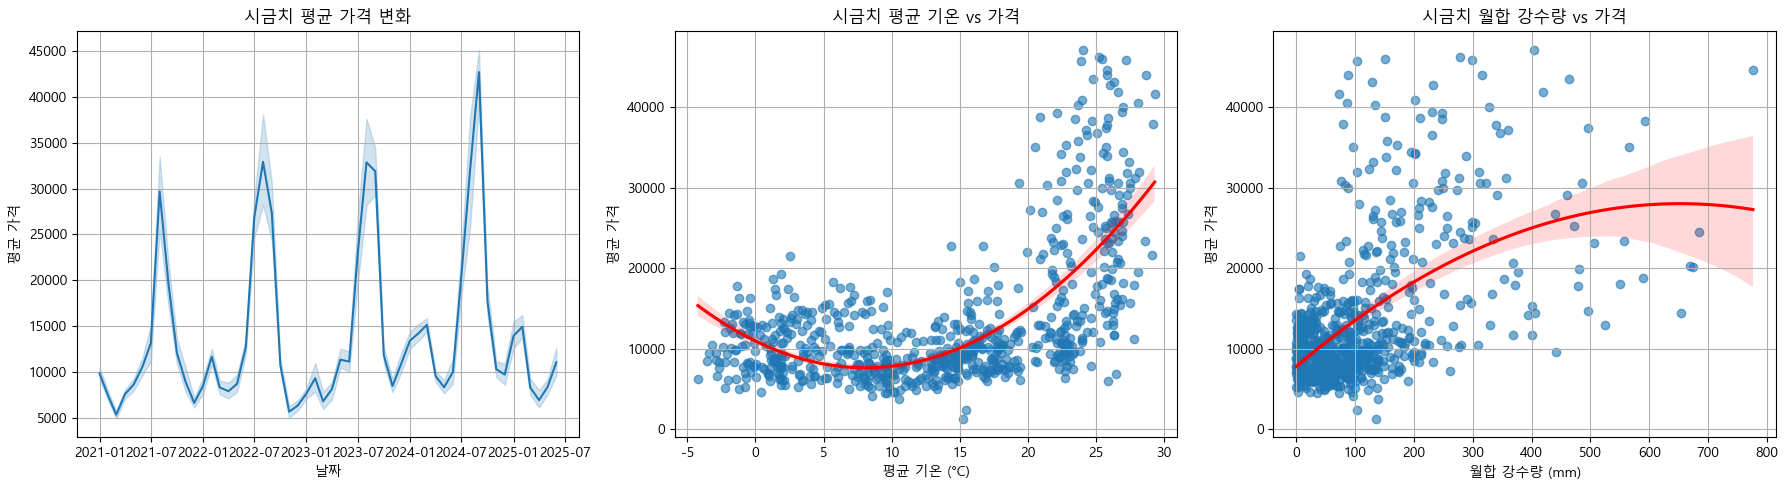

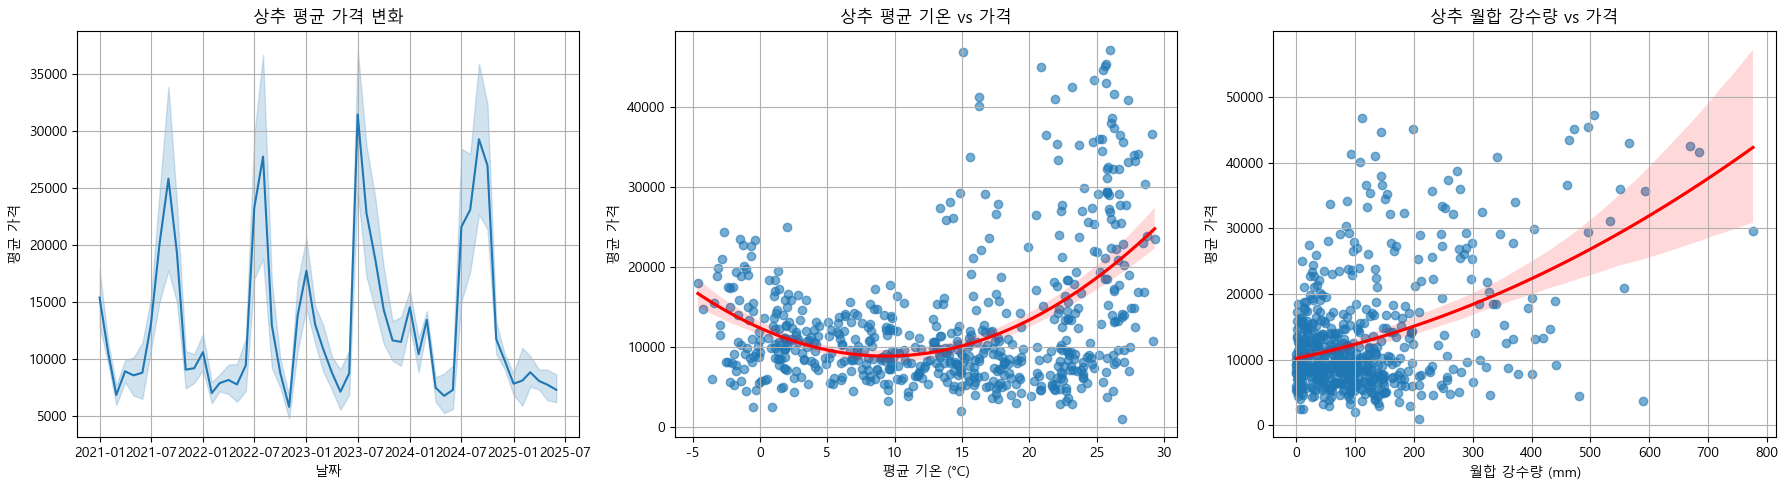

In [12]:
# 각 품목별로 날씨 변수와 평균가격 간의 상관관계 계산
weather_vars = ["평균기온(°C)", "월합강수량(00~24h만)(mm)", "평균풍속(m/s)", "최심적설(cm)"]
item_correlations = {}

for item in merged_df["품목"] .unique():
    item_df = merged_df[merged_df["품목"] == item].copy()
    if not item_df.empty and "평균가격" in item_df.columns:
        corrs = item_df[weather_vars + ["평균가격"]] .corr()
        if "평균가격" in corrs.columns:
            valid_corrs = corrs["평균가격"][:-1].dropna()
            if not valid_corrs.empty:
                item_correlations[item] = valid_corrs.abs() .max()

filtered_items = {k: v for k, v in item_correlations.items() if pd.notna(v)}
sorted_items = sorted(filtered_items.items(), key=lambda x: x[1], reverse=True)
top_items = [item for item, corr in sorted_items[:3]]

print(f"\n--- 날씨 변수와 상관관계가 높은 상위 품목: {top_items} ---\n")

for item in top_items:
    item_df = merged_df[merged_df["품목"] == item].copy()
    if item_df.empty:
        continue

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    sns.lineplot(data=item_df, x="날짜", y="평균가격", ax=axes[0])
    axes[0].set_title(f"{item} 평균 가격 변화")
    axes[0].set_xlabel("날짜")
    axes[0].set_ylabel("평균 가격")
    axes[0].grid(True)

    sns.regplot(data=item_df, x="평균기온(°C)", y="평균가격", order=2, scatter_kws={"alpha":0.6}, line_kws={"color":"red"}, ax=axes[1])
    axes[1].set_title(f"{item} 평균 기온 vs 가격")
    axes[1].set_xlabel("평균 기온 (°C)")
    axes[1].set_ylabel("평균 가격")
    axes[1].grid(True)

    sns.regplot(data=item_df, x="월합강수량(00~24h만)(mm)", y="평균가격", order=2, scatter_kws={"alpha":0.6}, line_kws={"color":"red"}, ax=axes[2])
    axes[2].set_title(f"{item} 월합 강수량 vs 가격")
    axes[2].set_xlabel("월합 강수량 (mm)")
    axes[2].set_ylabel("평균 가격")
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()